In [1]:
import os
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
def diff_two_w2v_all_nei(m1, m2, num_words):
    """
    Compute difference between two word2vec models based on each word's relationship with all the neighbors.
    """
    
    # pick common words between two embeddings and sort them
    common_vocab = set(m1.wv.vocab.keys())&set(m2.wv.vocab.keys())
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # convert gensim w2v to numpy array
    m1_np = np.zeros((num_words, 300))
    m2_np = np.zeros((num_words, 300))
    
    for i in range(num_words):
        vec = m1.wv[common_vocab[i]]
        m1_np[i] = vec
        vec = m2.wv[common_vocab[i]]
        m2_np[i] = vec
        
    # each vector represent a relationship between a word and all the other words + the word itself
    cosim_m1 = cosine_similarity(m1_np, m1_np)
    cosim_m2 = cosine_similarity(m2_np, m2_np)
    
    sem_diff = []
    
    for i in range(num_words):
        sem_diff.append(cosine_similarity(cosim_m1[i].reshape(1, -1), cosim_m2[i].reshape(1, -1))[0][0])
        
    return sem_diff, common_vocab

In [3]:
def diff_two_w2v_some_nei(m1, m2, num_words, num_nei):
    """
    Compute difference between two word2vec models based on each word's relationship with n nearest neighbors.
    """
    
    # pick common words between two embeddings and sort them
    common_vocab = set(m1.wv.vocab.keys())&set(m2.wv.vocab.keys())
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # convert gensim w2v to numpy array
    m1_np = np.zeros((num_words, 300))
    m2_np = np.zeros((num_words, 300))
    
    for i in range(num_words):
        vec = m1.wv[common_vocab[i]]
        m1_np[i] = vec
        vec = m2.wv[common_vocab[i]]
        m2_np[i] = vec
        
    # each vector represent a relationship between a word and all the other words + the word itself
    cosim_m1 = cosine_similarity(m1_np, m1_np)
    cosim_m2 = cosine_similarity(m2_np, m2_np)
    
    m1_closest_words = []
    m2_closest_words = []
    
    for w in range(len(cosim_m1)):
        closest = sorted(range(len(cosim_m1[w])), key=lambda i: cosim_m1[w][i], reverse=True)
        m1_closest_words.append(closest)
    
    #for w in range(len(cosim_m2)):
    #    closest = sorted(range(len(cosim_m2[w])), key=lambda i: cosim_m2[w][i], reverse=True)
    #    m2_closest_words.append(closest)
        
    n_closest_words_in_m1 = [] # 2000*num_nei matrix (num_nei neighboring words per each word)
    n_closest_words_in_m2 = []  # 2000*num_nei matrix (same as above)

    for i in range(num_words):
        word_m1 = [] # cosine simliarity between 20 neighboring words in m1
        word_m2 = []  # cosine simliarity between the same 20 words above in m2
        # exclude itself (so start with 1 not 0)
        for j in range(1,num_nei):
            nei_index = m1_closest_words[i][j]
            word_m1.append(cosim_m1[i][nei_index])
            word_m2.append(cosim_m2[i][nei_index])
        n_closest_words_in_m1.append(word_m1)
        n_closest_words_in_m2.append(word_m2)
        
    sem_diff = []

    for i in range(num_words):
        ith_word_m1 = np.asarray(n_closest_words_in_m1[i]).reshape(1, -1)
        ith_word_m2 = np.asarray(n_closest_words_in_m2[i]).reshape(1, -1)
        sem_diff.append(cosine_similarity(ith_word_m1, ith_word_m2)[0][0])
        
    return sem_diff, common_vocab

In [4]:
def most_diff_words(sem_diff, common_vocab, num):
    """
    print n most changing (or different) words and
    return the list of words sorted based on the degree of change (or difference) 
    """
    
    most_diff_words = sorted(range(len(sem_diff)), key=lambda i: sem_diff[i], reverse=False)

    print("Top", num, "most changing word: ")
    count = 0
    for i in most_diff_words:
        print(common_vocab[i], end = ' ')
        count += 1
        if count > num:
            break
            
    print("\n")
    return most_diff_words

In [5]:
def closest_word_in_other_model(m1, m2, word, num_words):
    """
    m1, m2: word2vec models
    word: word of interest in m1
    num_words: the number of common words shared between two embeddings
    
    return the closest words in m2 to the given word in m1
    """
    
    # pick common words between two embeddings and sort them
    common_vocab = set(m1.wv.vocab.keys())&set(m2.wv.vocab.keys())
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # convert gensim w2v to numpy array
    m1_np = np.zeros((num_words, 300))
    m2_np = np.zeros((num_words, 300))
    
    for i in range(num_words):
        vec = m1.wv[common_vocab[i]]
        m1_np[i] = vec
        vec = m2.wv[common_vocab[i]]
        m2_np[i] = vec
        
    # each vector represent a relationship between a word and all the other words + the word itself
    cosim_m1 = cosine_similarity(m1_np, m1_np)
    cosim_m2 = cosine_similarity(m2_np, m2_np)
    
    sem_diff = []
    
    word_neighbor_in_m1 = cosim_m1[common_vocab.index(word)]
    
    closest_word_in_m2_index = 0
    max_sim = 0

    for i in range(num_words):
        sim = cosine_similarity(word_neighbor_in_m1.reshape(1, -1), cosim_m2[i].reshape(1, -1))[0][0]
        if max_sim < sim:
            closest_word_in_m2_index = i
            max_sim = sim
    
    return common_vocab[closest_word_in_m2_index], max_sim

# Difference between parties, 1901-2019, 20 years per model

In [7]:
# Read word2vec models (3 parties, per 20 year)

year = '2001-2019'

con_6 = Word2Vec.load('300d_20win\\lipad'+year+'con.bin')
lib_6 = Word2Vec.load('300d_20win\\lipad'+year+'lib.bin')
dem_6 = Word2Vec.load('300d_20win\\lipad'+year+'dem.bin')

year = '1981-2000'

con_5 = Word2Vec.load('300d_20win\\lipad'+year+'con.bin')
lib_5 = Word2Vec.load('300d_20win\\lipad'+year+'lib.bin')
dem_5 = Word2Vec.load('300d_20win\\lipad'+year+'dem.bin')

year = '1961-1980'

con_4 = Word2Vec.load('300d_20win\\lipad'+year+'con.bin')
lib_4 = Word2Vec.load('300d_20win\\lipad'+year+'lib.bin')
dem_4 = Word2Vec.load('300d_20win\\lipad'+year+'dem.bin')

year = '1941-1960'

con_3 = Word2Vec.load('300d_20win\\lipad'+year+'con.bin')
lib_3 = Word2Vec.load('300d_20win\\lipad'+year+'lib.bin')
dem_3 = Word2Vec.load('300d_20win\\lipad'+year+'dem.bin')

year = '1921-1940'

con_2 = Word2Vec.load('300d_20win\\lipad'+year+'con.bin')
lib_2 = Word2Vec.load('300d_20win\\lipad'+year+'lib.bin')
dem_2 = Word2Vec.load('300d_20win\\lipad'+year+'dem.bin')

year = '1901-1920'

con_1 = Word2Vec.load('300d_20win\\lipad'+year+'con.bin')
lib_1 = Word2Vec.load('300d_20win\\lipad'+year+'lib.bin')

In [9]:
# difference b/w liberal and conservative

num_words = 3000
diff_list_lib_con = []

sem_diff, common_vocab = diff_two_w2v_all_nei(con_1, lib_1, num_words)
print("1901-1920 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_2, lib_2, num_words)
print("1921-1940 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_3, lib_3, num_words)
print("1941-1960 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_4, lib_4, num_words)
print("1961-1980 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_5, lib_5, num_words)
print("1981-2000 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_6, lib_6, num_words)
print("2001-2019 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

1901-1920 
Top 100 most changing word: 
scotia con nova grand hut tbe dot trunk foster georgian v t y pro sound edward neither apparently precisely deer breton w scarcely secret tlie rightly prince sproule o kingdom wilfrid marine supposing hudson jacques tupper laurier cold nevertheless mackenzie mann yukon cartier completely sam frederick usually monk sole fielding pre accordingly custom welland chinese don superior red patronage tion shell concession slight nan none utterly renfrew straight inland guysborough carvell strange brunswick highways yes hat columbia lennox peterborough ot tarte nor non lias oliver passage recruiting voluntary arthur unfortunately inasmuch graham assiniboia exchequer rouville distinct supreme f commanding brantford specially 

1921-1940 
Top 100 most changing word: 
furthermore scotia nova moreover mackenzie dot battleford manion yarmouth drayton nan w neither cahan motherwell t dispute precisely edward distinctly combines none temiscouata comox apparently

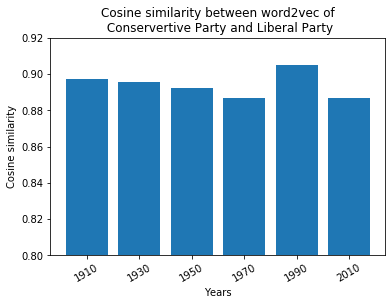

In [13]:
years = [1910, 1930, 1950, 1970, 1990, 2010]

index = np.arange(len(years))
plt.bar(index, diff_list_lib_con)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of\n Conservertive Party and Liberal Party')
axes = plt.gca()
axes.set_ylim([0.8,0.92])
plt.show()

In [11]:
# difference b/w liberal and NDP

diff_list_lib_dem = [0, 0]

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_3, lib_3, num_words)
print("1941-1960 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_4, lib_4, num_words)
print("1961-1980 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_5, lib_5, num_words)
print("1981-2000 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_6, lib_6, num_words)
print("2001-2019 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

1941-1960 
Top 100 most changing word: 
nan furthermore nova scotia edward william rosetown dot incidentally moreover quadra breton translation expedient biggar harris yes exchange conscription please square centre w assistant saint operative definitely consequently de movement electoral publicly neither albert mounted pool jaw apparently county l prefer churchill fraser usual senior selective desired john essex merchant naturally proceeding rank greenwood despite nil banking partly green imperial mackenzie hong seaway cooperative altogether cape normally meantime precisely planned description vocational kootenay gold o concrete armed fit box abbott wartime commanding progressive laurent arthur royal prince straight moose cross winkler wholly laurier uniform waste immigration reserve advance assiniboia group finally 

1961-1980 
Top 100 most changing word: 
yes knowles edward scotia furthermore nova presumably burnaby view x consequently please moreover seconded ordinary nil de bell na

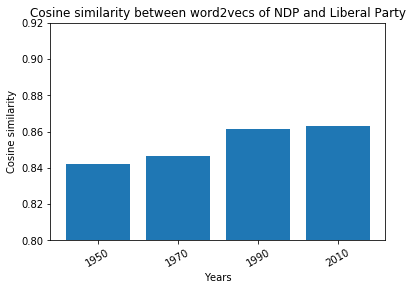

In [14]:
years = [1950, 1970, 1990, 2010]

index = np.arange(len(years))
plt.bar(index, diff_list_lib_dem[2:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vecs of NDP and Liberal Party')
axes = plt.gca()
axes.set_ylim([0.8,0.92])
plt.show()

In [15]:
# difference b/w liberal and conservative (only with some nearest neighbors)

num_words = 3000
num_nei = 20
diff_list_lib_con_some = []

sem_diff, common_vocab = diff_two_w2v_some_nei(con_1, lib_1, num_words, num_nei)
print("1901-1920 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con_some.append(sum(sem_diff)/len(sem_diff))
print("1 finished")

sem_diff, common_vocab = diff_two_w2v_some_nei(con_2, lib_2, num_words, num_nei)
print("1921-1940 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con_some.append(sum(sem_diff)/len(sem_diff))
print("2 finished")

sem_diff, common_vocab = diff_two_w2v_some_nei(con_3, lib_3, num_words, num_nei)
print("1941-1960 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con_some.append(sum(sem_diff)/len(sem_diff))
print("3 finished")

sem_diff, common_vocab = diff_two_w2v_some_nei(con_4, lib_4, num_words, num_nei)
print("1961-1980 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con_some.append(sum(sem_diff)/len(sem_diff))
print("4 finished")

sem_diff, common_vocab = diff_two_w2v_some_nei(con_5, lib_5, num_words, num_nei)
print("1981-2000 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con_some.append(sum(sem_diff)/len(sem_diff))
print("5 finished")

sem_diff, common_vocab = diff_two_w2v_some_nei(con_6, lib_6, num_words, num_nei)
print("2001-2019 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con_some.append(sum(sem_diff)/len(sem_diff))
print("6 finished")

1901-1920 
Top 100 most changing word: 
con scotia sound grand georgian friend general highways frankly yukon apparently reform pro v dundonald rightly latter mountain splendid non namely frank partly trunk extreme dot formerly sole tbe sight gentleman usual nevertheless shell altogether completely hut canals nova jacques particular precisely ot undoubtedly peace none rouville access really scarcely secret almost honestly itself than patronage red distinct today utterly again everybody premier regina wholly albert mine causes prince an first superior mackenzie reaching rural translation custom face prairie tion ever definite charlottetown broad real tory recruiting supplementary exhibition pockets specially alone messrs brantford still kingdom columbia robert accordingly warrant deep 

1 finished
1921-1940 
Top 100 most changing word: 
furthermore dispute none rightly moreover mackenzie light nova yarmouth temiscouata friend proceeds remaining scotia distinctly usual usually nan regard

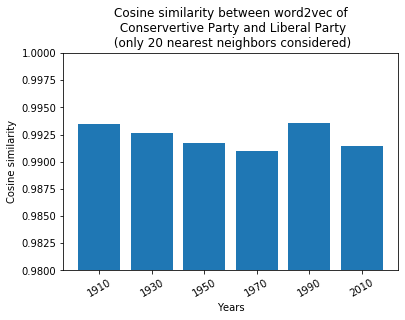

In [16]:
years = [1910, 1930, 1950, 1970, 1990, 2010]

index = np.arange(len(years))
plt.bar(index, diff_list_lib_con_some)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of\n Conservertive Party and Liberal Party\n (only 20 nearest neighbors considered)')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

In [17]:
num_words = 3000
diff_list_con_dem = [0, 0]

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_3, con_3, num_words)
print("1941-1960 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_4, con_4, num_words)
print("1961-1980 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_5, con_5, num_words)
print("1981-2000 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_6, con_6, num_words)
print("2001-2019 ")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

1941-1960 
Top 100 most changing word: 
furthermore edward scotia twillingate nova dot essex incidentally biggar bonavista churchill centre naturally exchange consequently rosetown reserve movement normally assiniboia arthur despite film banking senior box prefer translation saint brigade obviously group proceeding neither mounted gold venture mere green county parliamentary breton description jaw bar british orderly l apart progressive cooperative precisely pipe japanese above operative warning partly wartime south zealand q vocational anti kootenay altogether latter assistant pool historic white royal foundation ministry content desired grand wholly uniform fifth publicly printing seaway usual meantime old fleming superior hardly seeing america don knowles maritime insurance definitely criminal fit radio brunswick post 

1961-1980 
Top 100 most changing word: 
knowles edward nova olympic bell scotia breton saint cape simcoe escalation northwest metric design consequently british cros

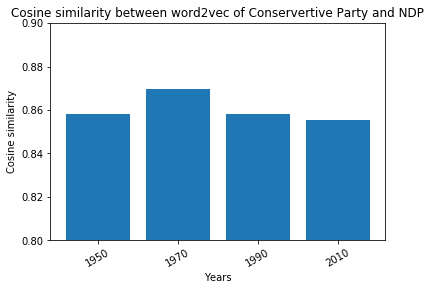

In [22]:
years = [1950, 1970, 1990, 2010]
    
index = np.arange(len(years))
plt.bar(index, diff_list_con_dem[2:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of \nConservertive Party and NDP')
axes = plt.gca()
axes.set_ylim([0.8,0.9])
plt.show()

In [25]:
women_men_sim = []

women_men_sim.append(con_1.similarity('woman', 'man'))
women_men_sim.append(con_2.similarity('woman', 'man'))
women_men_sim.append(con_3.similarity('woman', 'man'))
women_men_sim.append(con_4.similarity('woman', 'man'))
women_men_sim.append(con_5.similarity('woman', 'man'))
women_men_sim.append(con_6.similarity('woman', 'man'))


C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipyke

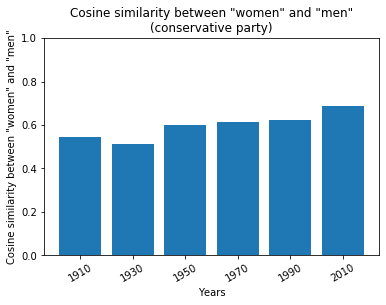

In [27]:
years = [1910, 1930, 1950, 1970, 1990, 2010]

index = np.arange(len(years))
plt.bar(index, women_men_sim)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity between "women" and "men"', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between "women" and "men"\n(Conservative Party)')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

In [28]:
women_men_sim = []

women_men_sim.append(lib_1.similarity('woman', 'man'))
women_men_sim.append(lib_2.similarity('woman', 'man'))
women_men_sim.append(lib_3.similarity('woman', 'man'))
women_men_sim.append(lib_4.similarity('woman', 'man'))
women_men_sim.append(lib_5.similarity('woman', 'man'))
women_men_sim.append(lib_6.similarity('woman', 'man'))

C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
C:\Users\Jungeun (June) Lim\Anaconda3\lib\site-packages\ipyke

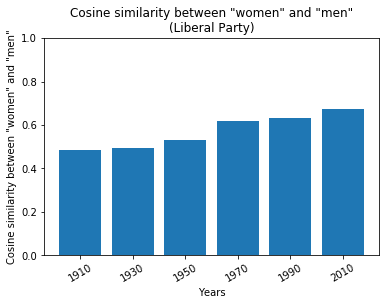

In [29]:
years = [1910, 1930, 1950, 1970, 1990, 2010]

index = np.arange(len(years))
plt.bar(index, women_men_sim)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity between "women" and "men"', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between "women" and "men"\n(Liberal Party)')
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

# Difference between parties, 1971-2019, 5 years per model

In [65]:
year = "1971-1975"

con_1 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_1 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_1 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "1976-1980"

con_2 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_2 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_2 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "1981-1985"

con_3 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_3 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_3 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "1986-1990"

con_4 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_4 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_4 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "1991-1995"

con_5 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_5 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_5 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "1996-2000"

con_6 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_6 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_6 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "2001-2005"

con_7 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_7 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_7 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "2006-2010"

con_8 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_8 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_8 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "2011-2015"

con_9 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_9 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_9 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

year = "2016-2019"

con_10 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_10 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')
dem_10 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')

In [30]:
num_words = 3000
diff_list_lib_con = []

sem_diff, common_vocab = diff_two_w2v_all_nei(con_1, lib_1, num_words)
print("1971-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_2, lib_2, num_words)
print("1976-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_3, lib_3, num_words)
print("1981-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_4, lib_4, num_words)
print("1986-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_5, lib_5, num_words)
print("1991-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_6, lib_6, num_words)
print("1996-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_7, lib_7, num_words)
print("2001-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_8, lib_8, num_words)
print("2006-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_9, lib_9, num_words)
print("2011-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_10, lib_10, num_words)
print("2016-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

1971-
Top 100 most changing word: 
scotia con nova grand hut tbe dot trunk foster georgian v t y pro sound edward neither apparently precisely deer breton w scarcely secret tlie rightly prince sproule o kingdom wilfrid marine supposing hudson jacques tupper laurier cold nevertheless mackenzie mann yukon cartier completely sam frederick usually monk sole fielding pre accordingly custom welland chinese don superior red patronage tion shell concession slight nan none utterly renfrew straight inland guysborough carvell strange brunswick highways yes hat columbia lennox peterborough ot tarte nor non lias oliver passage recruiting voluntary arthur unfortunately inasmuch graham assiniboia exchequer rouville distinct supreme f commanding brantford specially 

1976-
Top 100 most changing word: 
furthermore scotia nova moreover mackenzie dot battleford manion yarmouth drayton nan w neither cahan motherwell t dispute precisely edward distinctly combines none temiscouata comox apparently hudson pa

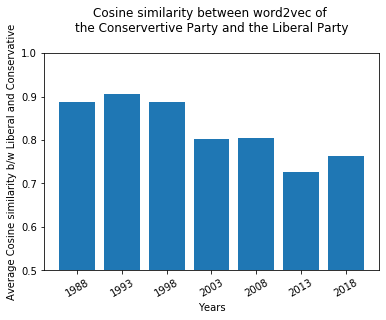

In [45]:
years = [1988, 1993, 1998, 2003, 2008, 2013, 2018]
    
index = np.arange(len(years))
plt.bar(index, diff_list_lib_con[3:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Average Cosine similarity b/w Liberal and Conservative', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of \nthe Conservertive Party and the Liberal Party\n')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [34]:
num_words = 3000
diff_list_lib_dem = []

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_1, lib_1, num_words)
print("1971-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_2, lib_2, num_words)
print("1976-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_3, lib_3, num_words)
print("1981-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_4, lib_4, num_words)
print("1986-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_5, lib_5, num_words)
print("1991-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_6, lib_6, num_words)
print("1996-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_7, lib_7, num_words)
print("2001-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_8, lib_8, num_words)
print("2006-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_9, lib_9, num_words)
print("2011-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_10, lib_10, num_words)
print("2016-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

1971-
Top 100 most changing word: 
yes furthermore publicly presumably naturally finally apparently constant view ordinary constantly none olympic publicity whenever reviewing exact pressing misleading minority complete fact upper gentleman declare moreover definite meantime advises arises green alleged please favourable wise urgent carter starting readily arising namely preliminary usual intensive translation concrete hyacinthe white crtc attempted disaster whitby computer surcharge satisfaction trust oshawa disposition talks promise edward false fit outstanding deferred consequently light seconded somehow partly premise endeavour charge whether undoubtedly games assembly agenda nil opening except bearing knowles initiatives criticism accordingly deliberately pulp adjourned closer immediately precise textile however absence oral prime fairly notices british drawing 

1976-
Top 100 most changing word: 
publicly knowles furthermore reaching deferred favourable exact beneficial undoubted

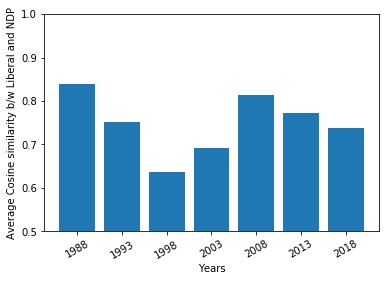

In [44]:
years = [1988,1993, 1998, 2003, 2008, 2013, 2018]
    
index = np.arange(len(years))
plt.bar(index, diff_list_lib_dem[3:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Average Cosine similarity b/w Liberal and NDP', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
#plt.title('Cosine similarity between word2vec of Conservertive Party and Liberal Party')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [37]:
years_and_ndp_seats = [(1979, 26), (1980, 32), (1984, 30), (1988, 43), 
         (1993, 9), (1997, 21), (2000, 13), (2004, 19),
        (2006, 29), (2008, 37), (2011, 103), (2015, 44),
        (2019, 24)]

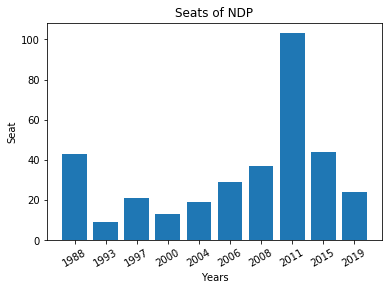

In [39]:
years = [1988, 1993, 1997, 2000, 2004,
        2006, 2008, 2011, 2015, 2019]
ndp_seats = [43, 9, 21, 13, 19, 29, 37, 103, 44, 24]
    
index = np.arange(len(years))
plt.bar(index, ndp_seats)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Seat', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Seats of NDP')
axes = plt.gca()
plt.show()

In [28]:
years = [1979, 1980, 1984, 1988, 
         1993, 1997, 2000, 2004,
        2006, 2008, 2011, 2015, 2019]    

dem_model = []
lib_model = []

for i in range(len(years)-1):
    dem_model.append(Word2Vec.load('300d_20win_ele\\300d_20winlipad'+str(years[i])+'-'+str(years[i+1])+'dem.bin'))
    lib_model.append(Word2Vec.load('300d_20win_ele\\300d_20winlipad'+str(years[i])+'-'+str(years[i+1])+'lib.bin'))

In [30]:
num_words = 3000
diff_list_lib_dem = []

for d, l in zip(dem_model, lib_model):
    sem_diff, common_vocab = diff_two_w2v_all_nei(d, l, num_words)
    diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

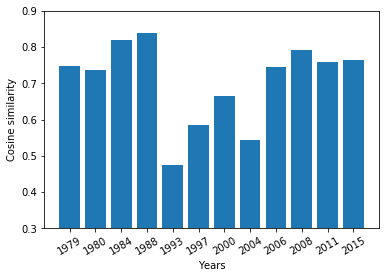

In [36]:
index = np.arange(len(years)-1)
plt.bar(index, diff_list_lib_dem)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Cosine similarity', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
#plt.title('Cosine similarity between word2vec of Conservertive Party and Liberal Party')
axes = plt.gca()
axes.set_ylim([0.3,0.9])
plt.show()

In [40]:
num_words = 3000
diff_list_con_dem = []

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_1, con_1, num_words)
print("1971-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_2, con_2, num_words)
print("1976-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_3, con_3, num_words)
print("1981-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_4, con_4, num_words)
print("1986-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_5, con_5, num_words)
print("1991-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_6, con_6, num_words)
print("1996-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_7, con_7, num_words)
print("2001-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_8, con_8, num_words)
print("2006-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_9, con_9, num_words)
print("2011-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_10, con_10, num_words)
print("2016-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

1971-
Top 100 most changing word: 
sifton major venture lion hut x manpower ot morrow patriotic franchise tbe publicly nan controls distinctly splendid reciprocity oliver promoters ease supplement patronage lias beg imperial depth pledge bounty usual edward light canals intercolonial inside georgian energy ministry issue corporate mother task bon cold scarcely concept marine expend dredge soldier liquor peculiar guaranteed standing upper autonomy commanding protective security preferential holders welfare inland trunk affairs housing u maclean redistribution opening sample write wilfrid pensioners carriers concern hudson lay admiralty her laurier studies lie piece terms distinct bargain planning shell veterans external settlers foundation owing arthur apparently wharfs custom fraud corps militia 

1976-
Top 100 most changing word: 
intimated sector venture redistribution morrow manion phase definitely reciprocity wholly evidently restraint her controls electors desires inasmuch trustee

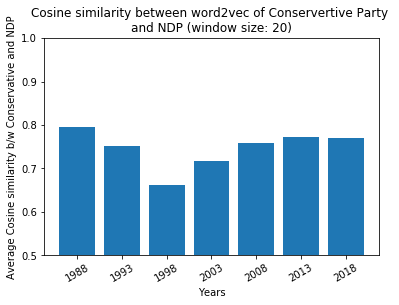

In [51]:
years = [1988, 1993, 1998, 2003, 2008, 2013, 2018]
    
index = np.arange(len(years))
plt.bar(index, diff_list_con_dem[3:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Average Cosine similarity b/w Conservative and NDP', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of Conservertive Party \nand NDP (window size: 20)')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

# Experiment with Window Size of 5

In [53]:
year = "1971-1975"

dem_1 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_1 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_1 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "1976-1980"

dem_2 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_2 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_2 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "1981-1985"

dem_3 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_3 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_3 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "1986-1990"

dem_4 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_4 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_4 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "1991-1995"

dem_5 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_5 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_5 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "1996-2000"

dem_6 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_6 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_6 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "2001-2005"

dem_7 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_7 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_7 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "2006-2010"

dem_8 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_8 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_8 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "2011-2015"

dem_9 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_9 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_9 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

year = "2016-2019"

dem_10 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'dem.bin')
con_10 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'con.bin')
lib_10 = Word2Vec.load('300d_20win_5y\\300d_20winlipad'+year+'lib.bin')

In [47]:
num_words = 3000
diff_list_con_dem = []

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_1, con_1, num_words)
print("1971-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_2, con_2, num_words)
print("1976-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_3, con_3, num_words)
print("1981-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_4, con_4, num_words)
print("1986-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_5, con_5, num_words)
print("1991-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_6, con_6, num_words)
print("1996-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_7, con_7, num_words)
print("2001-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_8, con_8, num_words)
print("2006-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_9, con_9, num_words)
print("2011-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_10, con_10, num_words)
print("2016-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_con_dem.append(sum(sem_diff)/len(sem_diff))

1971-
Top 100 most changing word: 
presumably publicly naturally olympic publicity upper remaining escalation olympics straight hopes fundy mere readily games legitimate apparently ad postmaster knowles favourable whatsoever closure football exact concrete partly kingdom disputes postal operative strikes promise gold economics edward content clarification coin contingency fighting principal exchange cross vis breton spirit british cida hamilton ill consensus improvements minor assumed white outstanding trust relative redistribution nova neither holding frequently columbia title initiatives band fairly proof hopefully minority personally drawing fiscal mines orderly truly bid deliberately sign bearing false bottom lalonde apart surcharge hardly none fishermen allotted once satisfactory universal crowfoot treasury reader fairness scotia complete re 

1976-
Top 100 most changing word: 
naturally knowles crosbie publicly strikes gatt presumably favourable furthermore beneficial x postmaste

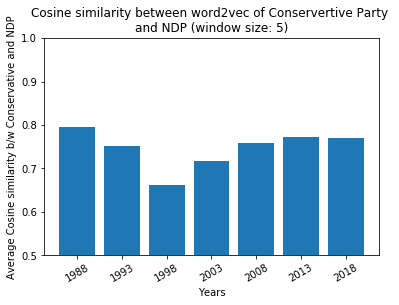

In [63]:
years = [1988, 1993, 1998, 2003, 2008, 2013, 2018]
    
index = np.arange(len(years))
plt.bar(index, diff_list_con_dem[3:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Average Cosine similarity b/w Conservative and NDP', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of Conservertive Party \nand NDP (window size: 5)')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [54]:
num_words = 3000
diff_list_lib_dem = []

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_1, lib_1, num_words)
print("1971-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_2, lib_2, num_words)
print("1976-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_3, lib_3, num_words)
print("1981-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_4, lib_4, num_words)
print("1986-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_5, lib_5, num_words)
print("1991-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_6, lib_6, num_words)
print("1996-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_7, lib_7, num_words)
print("2001-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_8, lib_8, num_words)
print("2006-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_9, lib_9, num_words)
print("2011-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(dem_10, lib_10, num_words)
print("2016-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_dem.append(sum(sem_diff)/len(sem_diff))

1971-
Top 100 most changing word: 
yes furthermore publicly presumably naturally finally apparently constant view ordinary constantly none olympic publicity whenever reviewing exact pressing misleading minority complete fact upper gentleman declare moreover definite meantime advises arises green alleged please favourable wise urgent carter starting readily arising namely preliminary usual intensive translation concrete hyacinthe white crtc attempted disaster whitby computer surcharge satisfaction trust oshawa disposition talks promise edward false fit outstanding deferred consequently light seconded somehow partly premise endeavour charge whether undoubtedly games assembly agenda nil opening except bearing knowles initiatives criticism accordingly deliberately pulp adjourned closer immediately precise textile however absence oral prime fairly notices british drawing 

1976-
Top 100 most changing word: 
publicly knowles furthermore reaching deferred favourable exact beneficial undoubted

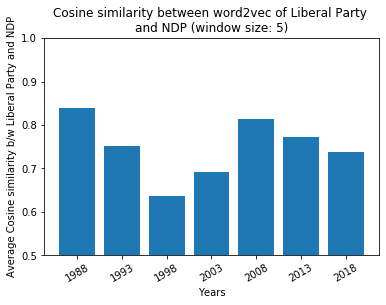

In [55]:
years = [1988, 1993, 1998, 2003, 2008, 2013, 2018]
    
index = np.arange(len(years))
plt.bar(index, diff_list_lib_dem[3:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Average Cosine similarity b/w Liberal Party and NDP', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of Liberal Party \nand NDP (window size: 5)')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [56]:
num_words = 3000
diff_list_lib_con = []

sem_diff, common_vocab = diff_two_w2v_all_nei(con_1, lib_1, num_words)
print("1971-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_2, lib_2, num_words)
print("1976-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_3, lib_3, num_words)
print("1981-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_4, lib_4, num_words)
print("1986-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_5, lib_5, num_words)
print("1991-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_6, lib_6, num_words)
print("1996-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_7, lib_7, num_words)
print("2001-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_8, lib_8, num_words)
print("2006-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_9, lib_9, num_words)
print("2011-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

sem_diff, common_vocab = diff_two_w2v_all_nei(con_10, lib_10, num_words)
print("2016-")
most_diff_words(sem_diff, common_vocab, 100)
diff_list_lib_con.append(sum(sem_diff)/len(sem_diff))

1971-
Top 100 most changing word: 
yes naturally mess view finally ad presumably moreover remaining seconded light fact hyacinthe breton bearing pressing edward please arises prime except constant whenever starting whelan what gentleman declare whether endeavour lang absence benson kingdom yet none consequently vis crowfoot british fit why how latter immediately sign precisely furthermore seat apparently columbia acting meantime reviewing closer universal constantly alleged cape apart arising coin uic striking neither confusion scotia ill accordingly postmaster ordinary once misleading re adequately notwithstanding olympics surrounding test fundy treasury exact ministerial green spite however turner paper freeze operative course absolutely unanimous contingency worst auto supplementary holding straight olympic secret 

1976-
Top 100 most changing word: 
ad crosbie furthermore presumably naturally yes lalonde moreover finally bearing please white closure arises accordingly turner metric

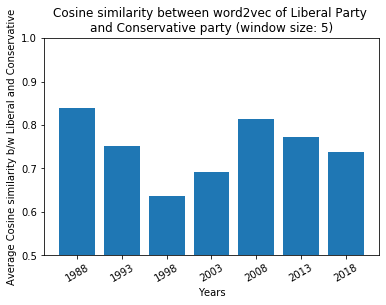

In [57]:
years = [1988, 1993, 1998, 2003, 2008, 2013, 2018]
    
index = np.arange(len(years))
plt.bar(index, diff_list_lib_dem[3:])
plt.xlabel('Years', fontsize=10)
plt.ylabel('Average Cosine similarity b/w Liberal and Conservative', fontsize=10)
plt.xticks(index, years, fontsize=10, rotation=30)
plt.title('Cosine similarity between word2vec of Liberal Party \nand Conservative party (window size: 5)')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()